# The control of human psycho-affective stability using differential equations

The purpose of this assignment is to model romantic relationship using **differential equations**. Two models are presented, **simple model**, the **strogatz model**, followed by **particular cases**. Finally, **stability** solutions are computed. 


## 1. The simple model

The first model is a simple one, it only assumes that the person's feelings are affected only by the other person's feelings. 

- **x(t)** represents **Romeo's feelings**
- **y(t)** represents **Juliet's feelings**

These feelings are measured on a scale of -1 to 1. Negatives values represents a level of anxiety. Positives values represents a level of affection. 

The feelings of the two lovers change's over time is decribed by the following system of differential equations : 

- **dx/dt = α * y(t)** 
- **dy/dt = β * x(t)**

Avec les conditions initiales suivantes : 

- **x(0) = x0** 
- **y(0) = y0**

The constants α and β denotes "terms of relationships".


In [2]:
# import libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


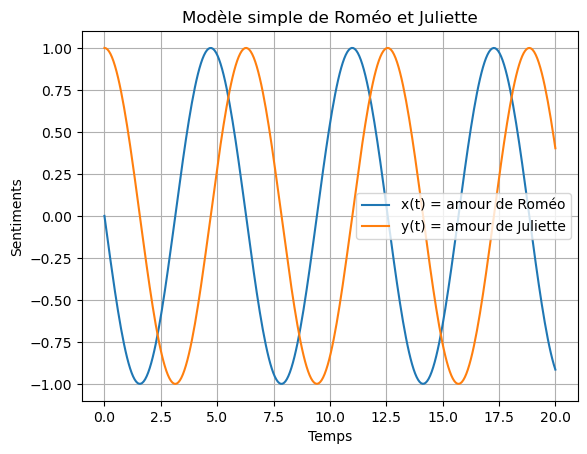

In [3]:
# --- Paramètres du modèle --- 
alpha = -1   # influence de Juliette sur Roméo
beta = 1  # influence de Roméo sur Juliette

# --- Système d'équations différentielles ---
def simple_model(t, Y):
    x, y = Y  # Y contient [x(t), y(t)]
    dxdt = alpha * y
    dydt = beta * x
    return [dxdt, dydt]

# --- Conditions initiales ---
x0, y0 = 0, 1
Y0 = [x0, y0]

# --- Plage de temps ---
t_span = (0 , 20)
t_eval = np.linspace(t_span[0], t_span[1], 300)

# --- Résolution numérique ---
sol = solve_ivp(simple_model, t_span, Y0, t_eval=t_eval)

# --- Tracé ---
plt.plot(sol.t, sol.y[0], label="x(t) = amour de Roméo")
plt.plot(sol.t, sol.y[1], label="y(t) = amour de Juliette")
plt.xlabel('Temps')
plt.ylabel('Sentiments')
plt.title('Modèle simple de Roméo et Juliette')
plt.legend()
plt.grid(True)
plt.show()


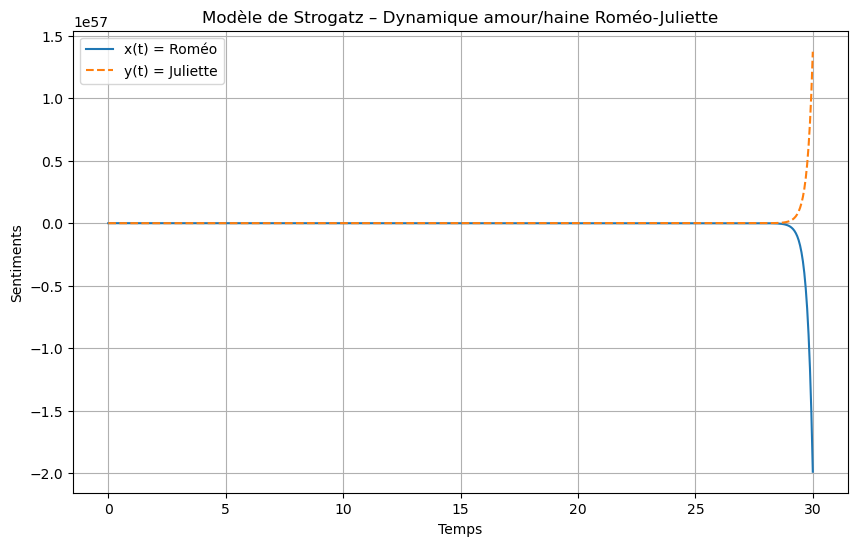

In [4]:
# --- Paramètres du modèle ---
# Ces coefficients définissent le style amoureux de Roméo et Juliette
a = 1   # Roméo influencé par ses propres émotions
b = -5   # Roméo influencé par Juliette
c = -1  # Juliette influencée par Roméo
d = 3   # Juliette influencée par elle-même

# --- Système d’équations différentielles ---
def strogatz_model(t, Y):
    x, y = Y   # x = Roméo, y = Juliette
    dxdt = a * x + b * y
    dydt = c * x + d * y
    return [dxdt, dydt]

# --- Conditions initiales ---
x0, y0 = 1.0, 0.5
Y0 = [x0, y0]

# --- Intervalle de temps ---
t_span = (0, 30)
t_eval = np.linspace(t_span[0], t_span[1], 500)

# --- Résolution numérique ---
sol = solve_ivp(strogatz_model, t_span, Y0, t_eval=t_eval)

# --- Tracés ---
plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[0], label="x(t) = Roméo")
plt.plot(sol.t, sol.y[1], '--', label="y(t) = Juliette")
plt.xlabel('Temps')
plt.ylabel('Sentiments')
plt.title('Modèle de Strogatz – Dynamique amour/haine Roméo-Juliette')
plt.legend()
plt.grid(True)
plt.show()

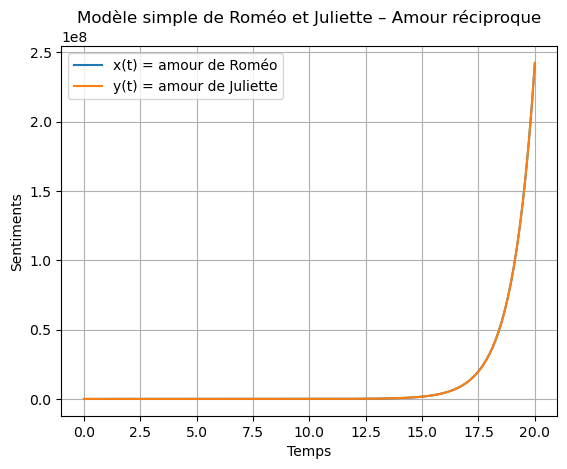

In [5]:
# --- Paramètres du modèle (Amour réciproque) ---
alpha = 1   # influence de Juliette sur Roméo
beta = 1    # influence de Roméo sur Juliette

# --- Système d'équations différentielles ---
def simple_model(t, Y):
    x, y = Y  # Y contient [x(t), y(t)]
    dxdt = alpha * y
    dydt = beta * x
    return [dxdt, dydt]

# --- Conditions initiales ---
x0, y0 = 0, 1
Y0 = [x0, y0]

# --- Plage de temps ---
t_span = (0 , 20)
t_eval = np.linspace(t_span[0], t_span[1], 300)

# --- Résolution numérique ---
sol = solve_ivp(simple_model, t_span, Y0, t_eval=t_eval)

# --- Tracé ---
plt.plot(sol.t, sol.y[0], label="x(t) = amour de Roméo")
plt.plot(sol.t, sol.y[1], label="y(t) = amour de Juliette")
plt.xlabel('Temps')
plt.ylabel('Sentiments')
plt.title('Modèle simple de Roméo et Juliette – Amour réciproque')
plt.legend()
plt.grid(True)
plt.show()


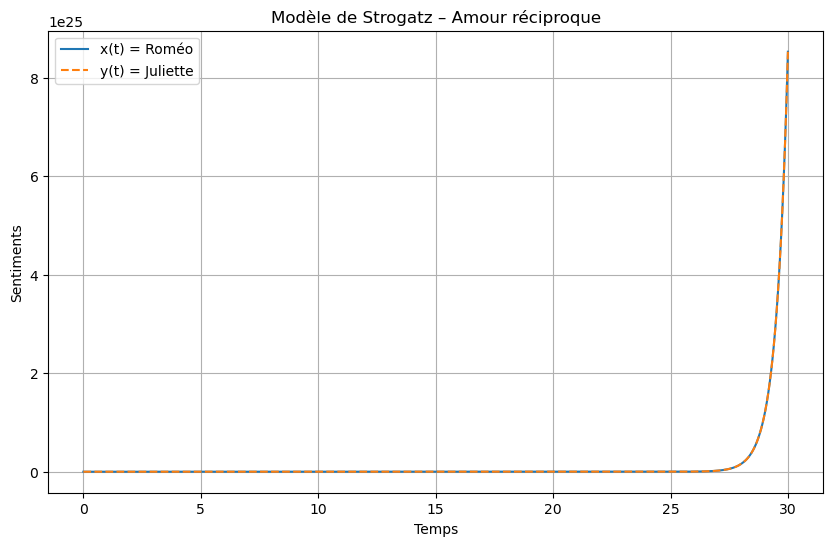

In [6]:
# --- Paramètres du modèle (Amour réciproque) ---
a = 1   # Roméo influencé par ses propres émotions
b = 1   # Roméo influencé par Juliette
c = 1   # Juliette influencée par Roméo
d = 1   # Juliette influencée par elle-même

# --- Système d’équations différentielles ---
def strogatz_model(t, Y):
    x, y = Y   # x = Roméo, y = Juliette
    dxdt = a * x + b * y
    dydt = c * x + d * y
    return [dxdt, dydt]

# --- Conditions initiales ---
x0, y0 = 1.0, 0.5
Y0 = [x0, y0]

# --- Intervalle de temps ---
t_span = (0, 30)
t_eval = np.linspace(t_span[0], t_span[1], 500)

# --- Résolution numérique ---
sol = solve_ivp(strogatz_model, t_span, Y0, t_eval=t_eval)

# --- Tracés ---
plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[0], label="x(t) = Roméo")
plt.plot(sol.t, sol.y[1], '--', label="y(t) = Juliette")
plt.xlabel('Temps')
plt.ylabel('Sentiments')
plt.title('Modèle de Strogatz – Amour réciproque')
plt.legend()
plt.grid(True)
plt.show()


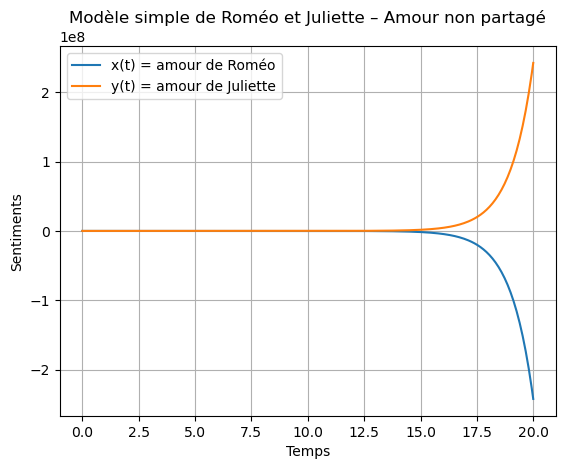

In [8]:
# --- Paramètres du modèle (Amour non partagé) ---
alpha = -1   # influence de Juliette sur Roméo
beta = -1    # influence de Roméo sur Juliette

# --- Système d'équations différentielles ---
def simple_model(t, Y):
    x, y = Y  # Y contient [x(t), y(t)]
    dxdt = alpha * y
    dydt = beta * x
    return [dxdt, dydt]

# --- Conditions initiales ---
x0, y0 = 0, 1
Y0 = [x0, y0]

# --- Plage de temps ---
t_span = (0 , 20)
t_eval = np.linspace(t_span[0], t_span[1], 300)

# --- Résolution numérique ---
sol = solve_ivp(simple_model, t_span, Y0, t_eval=t_eval)

# --- Tracé ---
plt.plot(sol.t, sol.y[0], label="x(t) = amour de Roméo")
plt.plot(sol.t, sol.y[1], label="y(t) = amour de Juliette")
plt.xlabel('Temps')
plt.ylabel('Sentiments')
plt.title('Modèle simple de Roméo et Juliette – Amour non partagé')
plt.legend()
plt.grid(True)
plt.show()

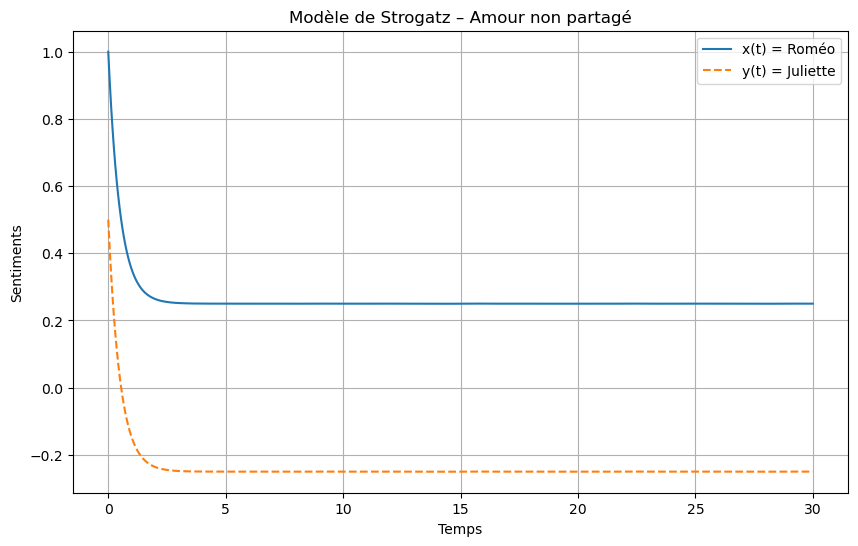

In [11]:
# --- Paramètres du modèle (Amour non partagé²) ---
a = -1   # Roméo influencé par ses propres émotions
b = -1   # Roméo influencé par Juliette
c = -1   # Juliette influencée par Roméo
d = -1   # Juliette influencée par elle-même

# --- Système d’équations différentielles ---
def strogatz_model(t, Y):
    x, y = Y   # x = Roméo, y = Juliette
    dxdt = a * x + b * y
    dydt = c * x + d * y
    return [dxdt, dydt]

# --- Conditions initiales ---
x0, y0 = 1.0, 0.5
Y0 = [x0, y0]

# --- Intervalle de temps ---
t_span = (0, 30)
t_eval = np.linspace(t_span[0], t_span[1], 500)

# --- Résolution numérique ---
sol = solve_ivp(strogatz_model, t_span, Y0, t_eval=t_eval)

# --- Tracés ---
plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[0], label="x(t) = Roméo")
plt.plot(sol.t, sol.y[1], '--', label="y(t) = Juliette")
plt.xlabel('Temps')
plt.ylabel('Sentiments')
plt.title('Modèle de Strogatz – Amour non partagé')
plt.legend()
plt.grid(True)
plt.show()
